第一种是金价对于ETF的固定关系，第二种是kalman之后做的pairs，现实情况中应该是第一种更加符合实际

In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from pykalman import KalmanFilter
from scipy.stats.mstats import winsorize

In [1]:
# 加载数据
etf = pd.read_csv("518880_SH_output.csv",usecols=['ReceiveDateTime', 'LastPx','Buy1Price','Sell1Price'])
au = pd.read_csv("AU99.99.SGE_20250101_20250630.csv",usecols=['ReceiveDateTime', 'LastPx','Buy1Price','Sell1Price'])

#清洗
#区分价格
etf.rename(columns={'LastPx': 'ETF_Price','Buy1Price':'ETF_Buy1Price','Sell1Price':'ETF_Sell1Price'}, inplace=True)
au.rename(columns={'LastPx': 'AU_Price','Buy1Price':'AU_Buy1Price','Sell1Price':'AU_Sell1Price'}, inplace=True)

#删去0值
etf = etf[etf['ETF_Price'] != 0]
au = au[au['AU_Price'] != 0]

#规范时间
etf['ReceiveDateTime'] = pd.to_datetime(etf['ReceiveDateTime'], format='%Y%m%d%H%M%S%f')
au['ReceiveDateTime'] = pd.to_datetime(au['ReceiveDateTime'], format='%Y%m%d%H%M%S%f')

#向前对齐现货价格
merged = pd.merge_asof(
    etf, au,
    on='ReceiveDateTime',
    direction='backward',
    suffixes=('_ETF', '_AU')
)

第一种方法

In [2]:
# === 1. 构造 IOPV 估值 ===
gold_per_unit_etf = 0.01
merged['IOPV_estimated'] = merged['AU_Price'] * gold_per_unit_etf
# === 2. 静态回归 ETF ~ IOPV ===
X = add_constant(merged['IOPV_estimated'])
y = merged['ETF_Price']
model = OLS(y, X).fit()
merged['fitted'] = model.predict(X)
# === 3. 残差和 rolling Z-score ===
merged['residual'] = merged['ETF_Price'] - merged['fitted']


/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/3425569864.py:7: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/3425569864.py:7: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/3425569864.py:7: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/3425569864.py:7: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/3425569864.py:7: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2

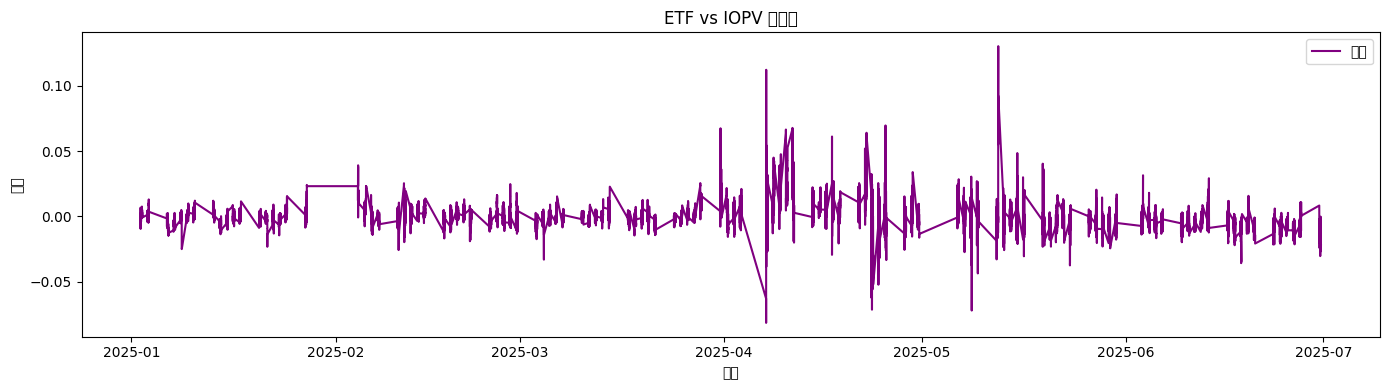

In [5]:
plt.figure(figsize=(14, 4))
plt.plot(merged['ReceiveDateTime'], merged['residual'], color='purple', label='残差')
plt.title('ETF vs IOPV 残差图')
plt.xlabel('时间')
plt.ylabel('差值')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# 改用 rolling mean 和 rolling std 计算 z-score，避免报错
window = 300
merged['res_mean'] = merged['residual'].rolling(window=window).mean()
merged['res_std'] = merged['residual'].rolling(window=window).std()
merged['zscore'] = (merged['residual'] - merged['res_mean']) / merged['res_std']

In [18]:
def rolling_median_mad_zscore(series, window):
    median = series.rolling(window).median()
    mad = series.rolling(window).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    return (series - median) / (1.4826 * mad)

merged['zscore_robust'] = rolling_median_mad_zscore(merged['residual'], window=300)

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/527501786.py:10: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/527501786.py:10: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/527501786.py:10: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/527501786.py:10: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/527501786.py:10: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2

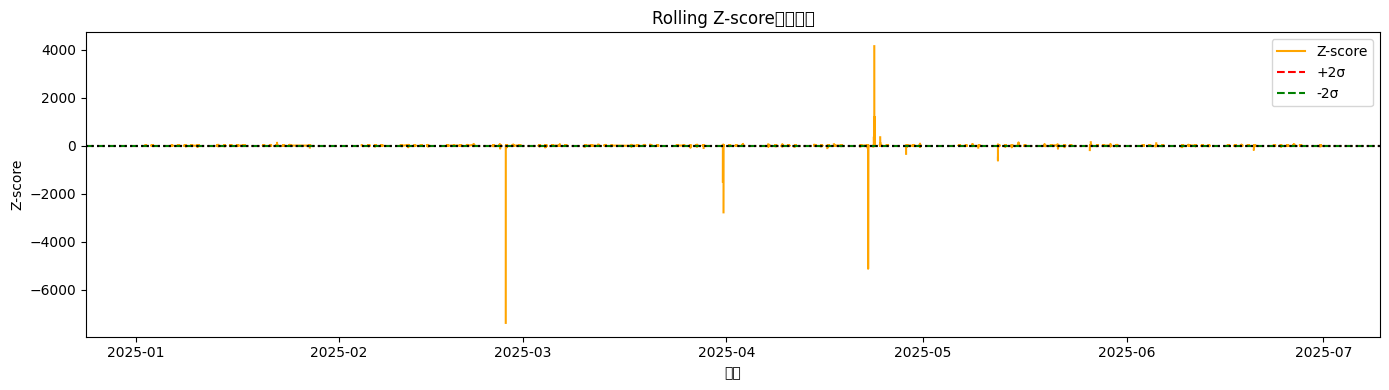

In [19]:
plt.figure(figsize=(14, 4))
plt.plot(merged['ReceiveDateTime'], merged['zscore_robust'], color='orange', label='Z-score')
plt.axhline(2, color='red', linestyle='--', label='+2σ')
plt.axhline(-2, color='green', linestyle='--', label='-2σ')
plt.axhline(0, color='black', linestyle=':')
plt.title('Rolling Z-score标准化图')
plt.xlabel('时间')
plt.ylabel('Z-score')
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/4003692813.py:42: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/4003692813.py:42: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/4003692813.py:42: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/4003692813.py:42: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/4003692813.py:42: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6p

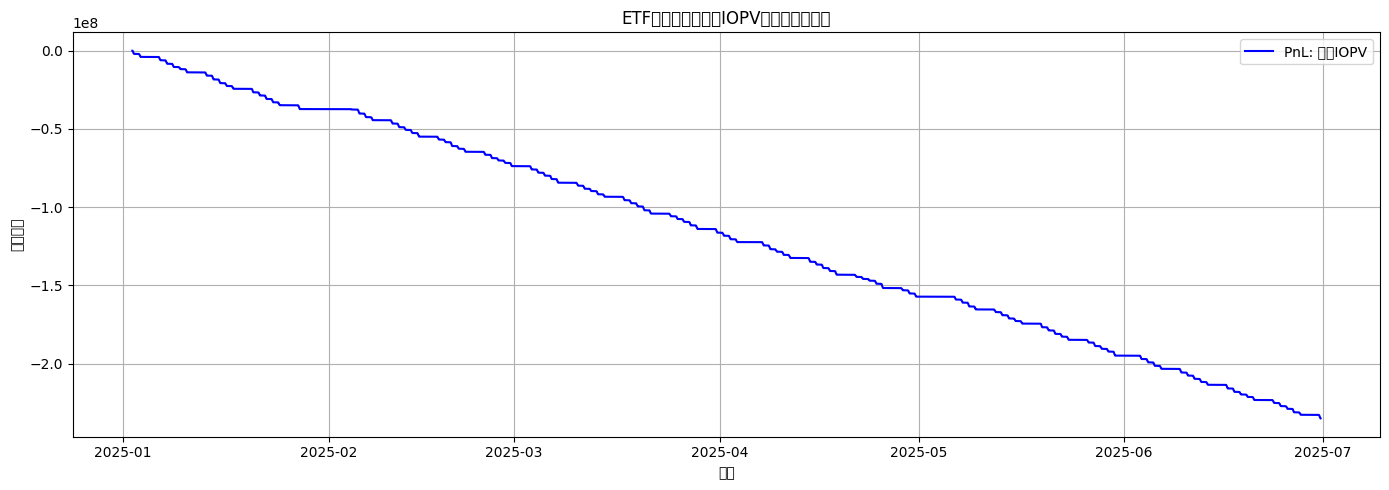

In [20]:
# === 4. 生成交易信号（z > 2 做空，z < -2 做多，z 穿越 0 平仓）===
merged['position'] = 0
for i in range(1, len(merged)):
    z_now = merged['zscore_robust'].iloc[i]
    z_prev = merged['zscore_robust'].iloc[i - 1]

    if z_now < -2:
        merged.loc[merged.index[i], 'position'] = 1
    elif z_now > 2:
        merged.loc[merged.index[i], 'position'] = -1
    elif z_prev * z_now < 0:
        merged.loc[merged.index[i], 'position'] = 0
    else:
        merged.loc[merged.index[i], 'position'] = merged['position'].iloc[i - 1]

# 7. 撮合交易并加入手续费 + 仓位份数计算
fee_rate = 0.0003 * 2
initial_cash = 1_000_000

merged['price_trade'] = np.nan
merged.loc[merged['position'] == 1, 'price_trade'] = merged['ETF_Sell1Price']
merged.loc[merged['position'] == -1, 'price_trade'] = merged['ETF_Buy1Price']

merged['price_shift'] = merged['price_trade'].shift(1)
merged['volume'] = initial_cash / merged['price_trade'].replace(0, np.nan)
merged['ret'] = (
    (merged['price_shift'] - merged['price_trade']) *
    merged['position'] * merged['volume'] -
    fee_rate * merged['ETF_Price'] * merged['volume']
)
merged['ret'] = merged['ret'].fillna(0)
merged['pnl'] = merged['ret'].cumsum()

# === 6. 可视化累计收益 ===
plt.figure(figsize=(14, 5))
plt.plot(merged['ReceiveDateTime'], merged['pnl'], label='PnL: 回归IOPV', color='blue')
plt.title("ETF套利策略：基于IOPV残差的撮合交易")
plt.xlabel("时间")
plt.ylabel("累计收益")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/2962155296.py:15: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/2962155296.py:15: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/2962155296.py:15: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/2962155296.py:15: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_28440/2962155296.py:15: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6p

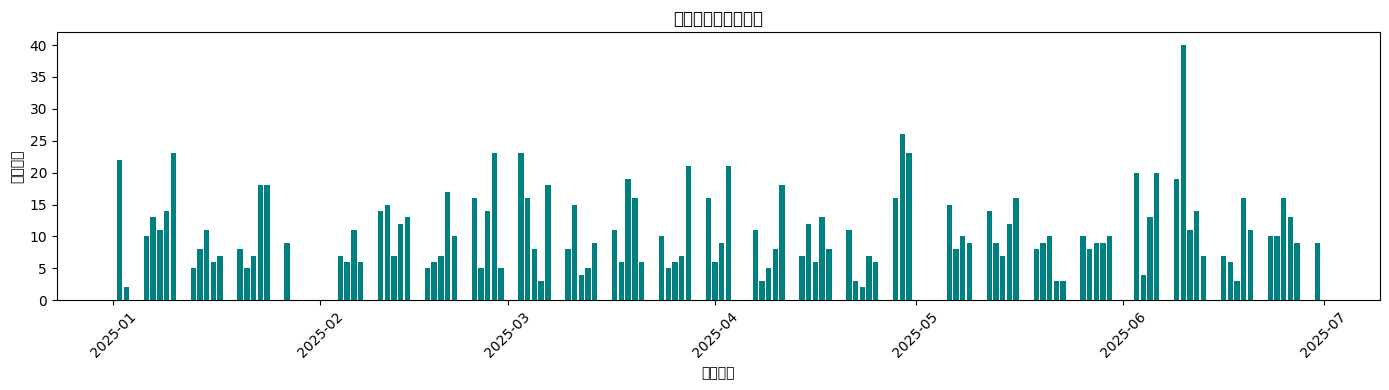

In [21]:
merged['position_change'] = merged['position'].diff()
trade_open = merged['position_change'].abs() == 2
trade_time = merged.loc[trade_open, 'ReceiveDateTime'].dt.date

# 每日统计
trade_counts = trade_time.value_counts().sort_index()

# 可视化
plt.figure(figsize=(14, 4))
plt.bar(trade_counts.index, trade_counts.values, color='teal')
plt.title("每日交易次数统计图")
plt.xlabel("交易日期")
plt.ylabel("交易次数")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#file_path = '518880.SH_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())


In [ ]:
#file_path = 'AU(T+D).SGE_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())

In [3]:
file_path = 'AU00.SHF_20250101_20250630.parquet'

# 使用 pandas 读取
df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
print(df.head())

df.to_csv('AU00.SHF_20250101_20250630.csv', index=False)


     MDDate     MDTime  SecurityType SecuritySubType SecurityID  \
0  20250102  085900500             8           08002       AU00   
1  20250102  090000500             8           08002       AU00   
2  20250102  090001000             8           08002       AU00   
3  20250102  090001500             8           08002       AU00   
4  20250102  090002000             8           08002       AU00   

   SecurityIDSource Symbol TradingPhaseCode  PreClosePx  NumTrades  ...  \
0               302   黄金主力                3      619.44        NaN  ...   
1               302   黄金主力                3      619.44        NaN  ...   
2               302   黄金主力                3      619.44        NaN  ...   
3               302   黄金主力                3      619.44        NaN  ...   
4               302   黄金主力                3      619.44        NaN  ...   

   SettlePrice  ReferencePrice  Buy1Price  Buy1OrderQty  Sell1Price  \
0          NaN             NaN     623.44          10.0      623.50   
1   

In [ ]:
#file_path = 'AU99.99.SGE_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())


第二种方法

In [ ]:
#封装cointegrated检验
def check_cointegration(df, etf_col='ETF_Price', au_col='AU_Price', time_col='ReceiveDateTime', freq='10S'):
    """
    对 ETF 和黄金现货价格进行协整检验（默认每10秒采样）。
    
    参数:
        df        : 包含时间和价格的原始tick数据（已经merge好的DataFrame）
        etf_col   : ETF价格列名
        au_col    : 黄金价格列名
        time_col  : 时间列名
        freq      : 重采样频率（如 '10S', '1T'）

    返回:
        p-value 和打印结论
    """
    df = df[[time_col, etf_col, au_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)

    # 降采样
    df_resampled = df.resample(freq).last().dropna()

    # 提取变量
    x = df_resampled[etf_col]
    y = df_resampled[au_col]

    # 协整检验
    score, pvalue, _ = coint(x, y)

    # 输出
    print(f"Cointegration test p-value: {pvalue:.5f}")
    if pvalue < 0.05:
        print("✅ 协整成立：可以构造均值回归配对策略")
    else:
        print("❌ 协整不显著：建议重新选择配对或继续观察")

    return pvalue

In [ ]:
#封装回归构造
def build_spread_and_zscore(df, etf_col='ETF_Price', au_col='AU_Price', window=300):
    """
    使用线性回归构造配对价差 spread，并基于 rolling Z-score 做标准化处理。
    
    参数:
        df       : 包含ETF和AU价格的 DataFrame
        etf_col  : ETF价格列名
        au_col   : AU价格列名
        window   : 滚动窗口大小（tick 数）
    
    返回:
        df       : 增加 spread, spread_mean, zscore 的原始 DataFrame
        beta     : 回归斜率
    """
    # 回归：ETF ~ AU
    X = sm.add_constant(df[au_col])
    y = df[etf_col]
    model = sm.OLS(y, X).fit()

    beta = model.params[1]

    # 构造 spread
    df['spread'] = df[etf_col] - beta * df[au_col]

    # rolling 均值 + std
    df['spread_mean'] = df['spread'].rolling(window).mean()
    df['spread_std'] = df['spread'].rolling(window).std()
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    return df, beta

In [ ]:
#kalman滤波器
def kalman_filter_beta(y, x, delta=1e-5, R=0.01, beta_init=0.0, P_init=1.0):
    """
    使用简易Kalman Filter估计动态 beta_t。
    y: 被解释变量（如 ETF）
    x: 解释变量（如 AU）
    delta: 状态转移噪声方差（越小越平滑）
    R: 观测噪声方差
    beta_init: 初始beta值
    P_init: 初始误差协方差
    返回: 动态beta序列
    """
    beta = beta_init
    P = P_init
    beta_series = []

    for t in range(len(x)):
        if np.isnan(x[t]) or np.isnan(y[t]):
            beta_series.append(np.nan)
            continue

        # 预测步骤
        beta_pred = beta
        P_pred = P + delta

        # 观测误差
        y_pred = beta_pred * x[t]
        e = y[t] - y_pred

        # Kalman增益
        K = P_pred * x[t] / (x[t]**2 * P_pred + R)

        # 更新
        beta = beta_pred + K * e
        P = (1 - K * x[t]) * P_pred

        beta_series.append(beta)

    return pd.Series(beta_series, index=y.index)

In [ ]:
#残差
# 提取价格
etf = merged['ETF_Price']
au = merged['AU_Price']

# 估计动态 β 序列
merged['beta_kalman'] = kalman_filter_beta(etf, au)

# 构造残差（spread）
merged['spread_kalman'] = etf - merged['beta_kalman'] * au

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(merged['ReceiveDateTime'], merged['beta_kalman'], label='Kalman β')
plt.title("动态估计的 β（Kalman Filter）")
plt.xlabel("时间")
plt.ylabel("β 值")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(merged['ReceiveDateTime'], merged['beta_kalman'], label='Kalman β', color='orange')
plt.title("Kalman 滤波器估计的 β 值随时间变化")
plt.xlabel("时间")
plt.ylabel("β 值")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
window = 300

# 滚动均值与标准差
merged['spread_kalman_mean'] = merged['spread_kalman'].rolling(window).mean()
merged['spread_kalman_std'] = merged['spread_kalman'].rolling(window).std()

# Z-score 标准化
merged['zscore_kalman'] = (merged['spread_kalman'] - merged['spread_kalman_mean']) / merged['spread_kalman_std']

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(merged['ReceiveDateTime'], merged['zscore_kalman'], label='Z-score (Kalman)', color='purple')
plt.axhline(2, color='red', linestyle='--', label='+2 入场阈值')
plt.axhline(-2, color='green', linestyle='--', label='-2 入场阈值')
plt.axhline(0, color='black', linestyle='-')
plt.title("基于 Kalman β 的滚动 Z-score")
plt.xlabel("时间")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
position = 0
entry_threshold = 2.0
exit_threshold = 0.1
etf_fee_rate = 0.0006  # ETF 双边万三手续费

entry_price_etf = 0
entry_price_au = 0

pnl_list = []
position_list = []

last_z = 0  # 上一tick的z-score，用于平仓判断

# 遍历每一tick
for i in range(len(merged)):
    row = merged.iloc[i]
    z = row['zscore_kalman']

    etf_buy = row['ETF_Sell1Price']      # 买入ETF（吃 ask）
    etf_sell = row['ETF_Buy1Price']      # 卖出ETF（吃 bid）
    au_buy = row['AU_Sell1Price']
    au_sell = row['AU_Buy1Price']

    pnl = 0

    if position == 0:
        if z > entry_threshold:
            # 做空ETF + 买入AU
            position = -1
            entry_price_etf = etf_sell
            entry_price_au = au_buy
        elif z < -entry_threshold:
            # 做多ETF + 卖出AU
            position = 1
            entry_price_etf = etf_buy
            entry_price_au = au_sell
        pnl_list.append(0)
        position_list.append(position)

    elif position == 1:
        if abs(z) < exit_threshold:
            # 平多头：ETF卖出，AU买入
            exit_etf = etf_sell
            exit_au = au_buy
            gross_pnl = (exit_etf - entry_price_etf) - (exit_au - entry_price_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)

    elif position == -1:
        if abs(z) < exit_threshold:
            # 平空头：ETF买入，AU卖出
            exit_etf = etf_buy
            exit_au = au_sell
            gross_pnl = (entry_price_etf - exit_etf) - (entry_price_au - exit_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)

# 记录
merged['position_kalman'] = position_list
merged['pnl_kalman'] = pnl_list
merged['cum_pnl_kalman'] = merged['pnl_kalman'].cumsum()

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(merged['ReceiveDateTime'], merged['cum_pnl_kalman'], label='Kalman策略累计收益', color='blue')
plt.title("基于 Kalman β 的配对交易策略 - 累计收益")
plt.xlabel("时间")
plt.ylabel("收益")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# 仓位变动：开仓或平仓
merged['position_shift'] = merged['position_kalman'].shift(1)
merged['position_change'] = merged['position_kalman'] != merged['position_shift']

# 取出变动的行，并提取日期
df_trades = merged[merged['position_change']].copy()
df_trades['date'] = df_trades['ReceiveDateTime'].dt.date

# 每日交易次数统计
daily_trade_counts = df_trades.groupby('date').size().reset_index(name='trade_count')

# 画图
plt.figure(figsize=(14, 6))
plt.bar(daily_trade_counts['date'], daily_trade_counts['trade_count'], width=1.0, color='steelblue')
plt.title("每日交易次数分布")
plt.xlabel("交易日")
plt.ylabel("交易次数")
plt.grid(True)
plt.tight_layout()
plt.show()